In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Store the age data in a pandas DataFrame.
data = {
    "event": ["GS-1", "GS-2.1c", "GS-2.2", "GS-3", "GS-4", "GS-5.1", "GS-5.2", "GS-6", "GS-7", "GS-8",
              "GS-9", "GS-10", "GS-11", "GS-12", "GS-13", "GS-14", "GS-15.1", "GS-15.2", "GS-16.1", "GS-16.2",
              "GS-17.1", "GS-17.2", "GS-18", "GS-19.1", "GS-19.2", "GS-20", "GS-21.1", "GS-21.2", "GS-22",
              "GS-23.1", "GS-23.2", "GS-24.1", "GS-24.2", "GS-25", "GS-26"],
    "end":   [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040, 104520, 106750, 108280, 115370],
    "start": [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380, 105440, 106900, 110640, 119140],

    "end_err": [4, 4, 20, 20, 20, 20, 60, 20, 20, 20,
                20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
                20, 20, 20, 20, 20, 20, 20, 20, 20,
                20, 20, 20, 40, 40, 40], 

    "start_err": [4, 20, 20, 60, 20, 60, 60, 60, 60, 60,
                  60, 60, 60, 60, 100, 100, 20, 20, 60, 20, 
                  60, 20, 20, 60, 200, 60, 100, 20, 60, 
                  60, 20, 40, 40, 40, 40]

}

# convert data to DataFrame
df_stadial = pd.DataFrame(data)



In [12]:
def check_sequence(data):

    events = data["event"]
    ends = data["end"]
    starts = data["start"]
    n = len(events)

    # We'll check up to the second-to-last event (i+1 should exist).
    for i in range(n - 1):
        # Ensure end[i] < start[i] < end[i+1] < start[i+1]
        if not (ends[i] < starts[i] < ends[i+1] < starts[i+1]):
            print(f"Order violation at indices {i} and {i+1}:\n"
                  f"  event[i] = {events[i]},   end[i] = {ends[i]}, start[i] = {starts[i]}\n"
                  f"  event[i+1] = {events[i+1]}, end[i+1] = {ends[i+1]}, start[i+1] = {starts[i+1]}")
            return False

    return True



In [13]:
check_sequence(data)

True

In [3]:
import random

def gen_ran_transitions(data, N_ran=1):
    """
    Generate N_ran dictionaries of resampled start/end ages,
    ensuring end < start and skipping randomization of the first 'end'
    and last 'start'.
    
    Parameters:
    -----------
    data : dict
        Original dictionary with keys:
          "event", "end", "start", "end_err", "start_err".
    N_ran : int
        How many resampled dictionaries to create.
        
    Returns:
    --------
    list of dict
        A list of dictionaries. Each dictionary has:
           "event", "end", "start"
        with randomly sampled values (except for the first end
        and the last start).
    """
    events = data["event"]
    ends = data["end"]
    starts = data["start"]
    end_errs = data["end_err"]
    start_errs = data["start_err"]

    n_events = len(events)
    all_resampled = []

    for _ in range(N_ran):
        # Prepare new dict of the same structure
        new_data = {
            "event": [],
            "end":   [],
            "start": []
        }

        for i in range(n_events):
            # Copy event name
            new_data["event"].append(events[i])

            # Decide whether to randomize 'end'
            if i == 0:
                # Skip randomization for the *first* end
                # Keep the original
                rand_end = ends[i]
            else:
                # Randomize within ± err range
                e_min = ends[i] - end_errs[i]
                e_max = ends[i] + end_errs[i]
                
                # We'll sample repeatedly until end < start
                # but we haven't sampled start yet, so let's do it inside a while loop
                # that also samples 'start'.
                rand_end = None  # placeholder

            # Decide whether to randomize 'start'
            if i == n_events - 1:
                # Skip randomization for the *last* start
                # Keep the original
                rand_start = starts[i]
            else:
                # We'll pick this inside the while loop if we do random sampling
                rand_start = None  # placeholder

            # If both 'end' and 'start' are not being randomized, no need for while loop
            if i == 0 and i == n_events - 1:
                # Means there's only one event? (Unusual, but just in case.)
                # Keep both as original.
                pass
            else:
                # Keep sampling until end < start
                # (If either end or start is fixed, it will remain in the loop but won't change.)
                while True:
                    # Randomize 'end' if needed
                    if i != 0:
                        rand_end = random.uniform(e_min, e_max)
                    else:
                        # i == 0, so end is fixed, do nothing
                        pass

                    # Randomize 'start' if needed
                    if i != n_events - 1:
                        s_min = starts[i] - start_errs[i]
                        s_max = starts[i] + start_errs[i]
                        rand_start = random.uniform(s_min, s_max)
                    else:
                        # i == last row => start is fixed, do nothing
                        pass

                    # Check if end < start
                    if rand_end < rand_start:
                        break  # valid pair found, exit the loop

            # Assign the final chosen (or original) values
            new_data["end"].append(rand_end)
            new_data["start"].append(rand_start)

        all_resampled.append(new_data)

    return all_resampled



In [18]:
random_GS_transitions = gen_ran_transitions(data, N_ran=500)

# loop through random samples and check the sequence
for i, sample in enumerate(random_GS_transitions):
    print(f"Random sample {i+1}")
    result=check_sequence(sample)
    print(f"Sequence check: {result}")
    if not result:
        break
    print("\n")

Random sample 1
Sequence check: True


Random sample 2
Sequence check: True


Random sample 3
Sequence check: True


Random sample 4
Sequence check: True


Random sample 5
Sequence check: True


Random sample 6
Sequence check: True


Random sample 7
Sequence check: True


Random sample 8
Sequence check: True


Random sample 9
Sequence check: True


Random sample 10
Sequence check: True


Random sample 11
Sequence check: True


Random sample 12
Sequence check: True


Random sample 13
Sequence check: True


Random sample 14
Sequence check: True


Random sample 15
Sequence check: True


Random sample 16
Sequence check: True


Random sample 17
Sequence check: True


Random sample 18
Sequence check: True


Random sample 19
Sequence check: True


Random sample 20
Sequence check: True


Random sample 21
Sequence check: True


Random sample 22
Sequence check: True


Random sample 23
Sequence check: True


Random sample 24
Sequence check: True


Random sample 25
Sequence check: True


Random sa

In [19]:
# save random gs transitions to /output using pickle
import pickle

with open("output/random_GS_transitions.pkl", "wb") as f:
    pickle.dump(random_GS_transitions, f)

In [20]:
# read GS transitions from /output using pickle
with open("output/random_GS_transitions.pkl", "rb") as f:
    random_GS_transitions = pickle.load(f)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def gen_ran_stadial_percentage(data, L_win, S_step, if_plot=False):
    """
    Compute the stadial coverage within a sliding window (length=L_win, step=S_step)
    for the provided stadial intervals (df_stadial), and interpolate insolation data
    (precession: df_pre, obliquity: df_obl) to match the resulting time axis.
    
    Parameters
    ----------
    df_stadial : pd.DataFrame
        Must contain columns 'event', 'start', 'end'.
        'start' > 'end' in terms of "years before present" 
        (e.g., start=119140, end=11703).
    L_win : float
        Window length in years for computing stadial coverage.
    S_step : float
        Sliding step in years for computing stadial coverage.
    df_pre : pd.DataFrame
        Must contain columns ['age', 'pre']. 'age' in years before present.
        Example: read from a local file.
    df_obl : pd.DataFrame
        Must contain columns ['age', 'obl']. 'age' in years before present.
        Example: read from a local file.
    if_plot : bool
        Whether to plot intermediate checks and final time series. Defaults to False.
    
    Returns
    -------
    df_stadial_interp : pd.DataFrame
        Columns: ['age', 'stadial_percent'] on a 100-year grid.
        'age' is from 0 to ~ (max window center), going from left (0) to older times.
    df_pre_interp : pd.DataFrame
        Columns: ['age', 'pre'], interpolated on the same 100-year grid as df_stadial_interp,
        but with age running from older to younger (e.g., ~120000 down to 0).
    df_obl_interp : pd.DataFrame
        Columns: ['age', 'obl'], similarly interpolated and oriented as df_pre_interp.
    """
    df_stadial = pd.DataFrame(data)
    # 1) Determine the overall time span of the stadial intervals.
    #    (older means larger number of years before present)
    overall_older = df_stadial["start"].max()  # e.g., 119140
    overall_recent = df_stadial["end"].min()   # e.g., 11703
    
    # 2) Prepare sliding windows from older to recent, stepping backward in time.
    #    We go from overall_older down to overall_recent, in steps of S_step
    #    but ensure the window is wide enough to include the last portion:
    w_old_values = np.arange(overall_older, overall_recent + L_win - 1, -S_step)
    
    window_centers = []
    stadial_percentages = []
    
    # 3) For each sliding window, compute stadial coverage
    for w_old in w_old_values:
        w_recent = w_old - L_win  # younger boundary
        # midpoint of the window (for storing in 'window_centers')
        win_center = w_old - (L_win / 2.0)
        
        total_overlap = 0.0
        
        # Accumulate the overlap between each stadial event and the current window
        for idx, row in df_stadial.iterrows():
            # An event is [event_end, event_start] in "years before present"
            event_end = row["end"]
            event_start = row["start"]
            
            # Overlap with the window [w_recent, w_old]
            overlap = max(0.0, min(w_old, event_start) - max(w_recent, event_end))
            total_overlap += overlap
        
        # Compute the fraction (in %) of L_win that is stadial coverage
        pct = (total_overlap / L_win) * 100.0
        window_centers.append(win_center)
        stadial_percentages.append(pct)
    
    # Convert to numpy arrays for sorting and interpolation
    window_centers = np.array(window_centers)
    stadial_percentages = np.array(stadial_percentages)
    
    # If requested, plot the raw (unsorted) coverage vs. window_centers
    if if_plot:
        plt.figure()
        plt.plot(window_centers, stadial_percentages, marker='', linestyle='-')
        plt.xlabel("Years before present (window center)")
        plt.ylabel("Stadial Coverage (%)")
        plt.title("Raw Stadial Coverage in Sliding Windows")
        # plt.grid(True)
        plt.show()

    
    # 4) Sort by ascending time (from most recent to oldest is typical, but let's unify):
    #    Actually, the next code sorts from smallest to largest "window_centers" for interpolation
    sort_idx = np.argsort(window_centers)
    x_sorted = window_centers[sort_idx]
    y_sorted = stadial_percentages[sort_idx]
    
    # Build a new time axis at 100-year resolution
    # from the minimum to the maximum of x_sorted
    x_min = x_sorted[0]
    x_max = x_sorted[-1]
    new_x = np.arange(x_min, x_max + 1, 100)
    
    # Perform linear interpolation for stadial coverage
    new_y = np.interp(new_x, x_sorted, y_sorted)
    
    # 5) Flip new_x so that it runs from 0 to ~max_age (left to right = younger to older in final code)
    #    This is the same logic as in the user's code:
    new_x = (new_x - new_x.max()) * -1.0
    new_x = np.abs(new_x)
    
    # If requested, plot the interpolated coverage
    if if_plot:
        plt.figure()
        plt.plot(new_x, new_y, marker='', linestyle='-')
        plt.xlabel("Years before present (window center)")
        plt.ylabel("Stadial Coverage (%)")
        plt.title("Interpolated Stadial Coverage (100-yr spacing)")
        # plt.grid(True)
        plt.show()
    
    # We now have stadial coverage in (new_x, new_y), where new_x runs from 0 up to ~max_age
    # Let's define the final DataFrame for stadial coverage
    df_stadial_interp = pd.DataFrame({
        "age": new_x,
        "stadial_percent": new_y
    })
    
 
    return df_stadial_interp


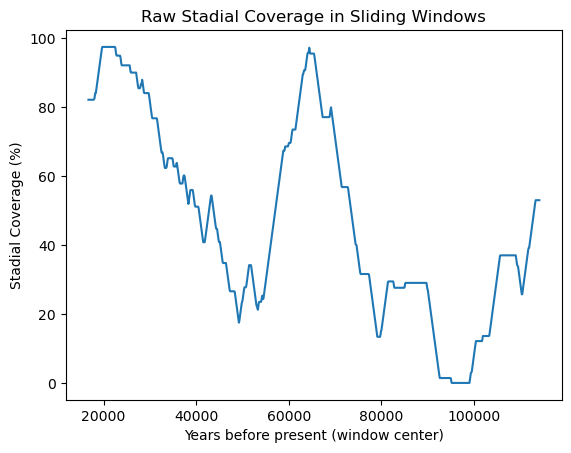

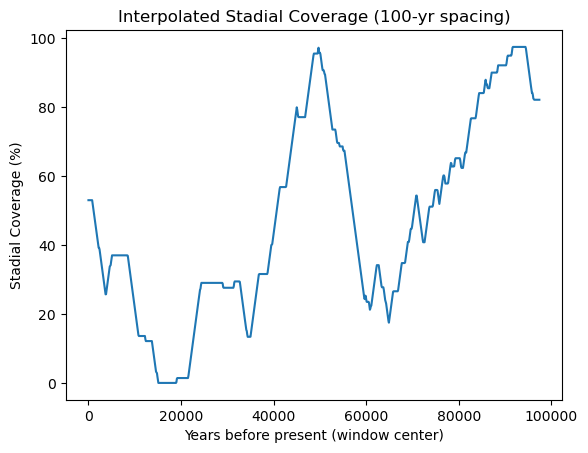

Random sample 1


Random sample 2


Random sample 3


Random sample 4


Random sample 5


Random sample 6


Random sample 7


Random sample 8


Random sample 9


Random sample 10


Random sample 11


Random sample 12


Random sample 13


Random sample 14


Random sample 15


Random sample 16


Random sample 17


Random sample 18


Random sample 19


Random sample 20


Random sample 21


Random sample 22


Random sample 23


Random sample 24


Random sample 25


Random sample 26


Random sample 27


Random sample 28


Random sample 29


Random sample 30


Random sample 31


Random sample 32


Random sample 33


Random sample 34


Random sample 35


Random sample 36


Random sample 37


Random sample 38


Random sample 39


Random sample 40


Random sample 41


Random sample 42


Random sample 43


Random sample 44


Random sample 45


Random sample 46


Random sample 47


Random sample 48


Random sample 49


Random sample 50


Random sample 51


Random sample 52


Random sample 53


Ra

In [29]:
df_stadial_win10000_step100 = gen_ran_stadial_percentage(random_GS_transitions[4], L_win=10000, S_step=100, if_plot=True)


# loop though random gs transitions and compute stadial percentage, then store all dfs in a list
df_stadial_win10000_step100_ran500 = []
for i, sample in enumerate(random_GS_transitions):
    print(f"Random sample {i+1}")
    df_stadial_win10000_step100 = gen_ran_stadial_percentage(sample, L_win=10000, S_step=100)
    df_stadial_win10000_step100_ran500.append(df_stadial_win10000_step100)
    print("\n")

In [31]:
# store df_stadial_win10000_step100_ran500 to /output using pickle
with open("output/df_stadial_win10000_step100_ran500.pkl", "wb") as f:
    pickle.dump(df_stadial_win10000_step100_ran500, f)

In [32]:
# read df_stadial_win10000_step100_ran500 from /output using pickle
with open("output/df_stadial_win10000_step100_ran500.pkl", "rb") as f:
    df_stadial_win10000_step100_ran500 = pickle.load(f)

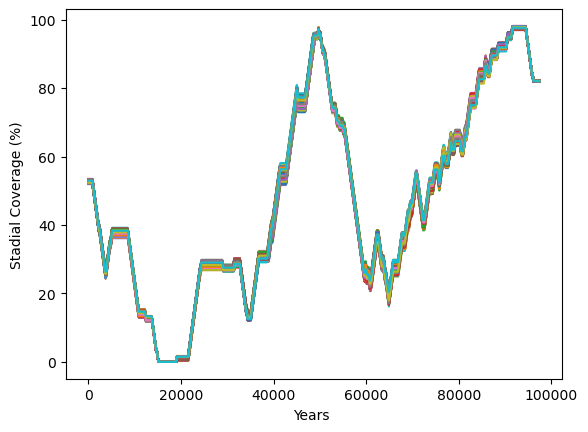

In [30]:
# loop through df_stadial_win10000_step100_ran500 and plot all time series of stadial percentage in a single plot
plt.figure()
for df in df_stadial_win10000_step100_ran500:
    plt.plot(df["age"], df["stadial_percent"], marker='', linestyle='-')
plt.xlabel("Years ")
plt.ylabel("Stadial Coverage (%)")
# plt.title("Stadial Coverage in Sliding Windows")
plt.show()

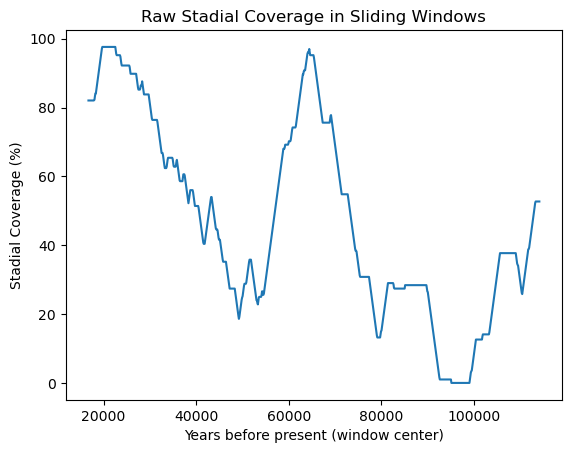

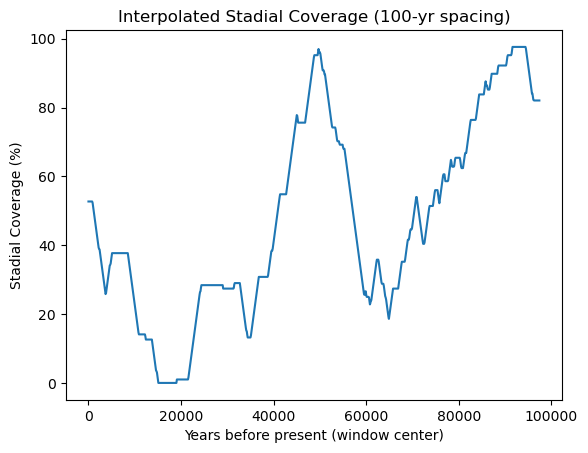

In [25]:
df_stadial_interp = gen_ran_stadial_percentage(data, L_win=10000, S_step=100, if_plot=True)

In [ ]:
import matplotlib.pyplot as plt

def visualize_transitions(data):
    """
    Plots vertical red lines at each 'end' and vertical blue lines at each 'start',
    and places an event label between each pair of lines.
    """
    events = data["event"]
    ends = data["end"]
    starts = data["start"]
    
    fig, ax = plt.subplots(figsize=(20, 3))
    
    n_events = len(events)
    for i, event in enumerate(events):
        e = ends[i]
        s = starts[i]
        
        # Plot vertical lines:
        ax.axvline(x=e, color='red', linewidth=1.5)
        ax.axvline(x=s, color='blue', linewidth=1.5)

        # Place text label in the middle of end and start, 
        # and at a vertical position that spreads them out (0..1).
        mid_x = (e + s) / 2
        y_pos = (i + 1) / (n_events + 1)  # distribute labels vertically
        ax.text(mid_x, y_pos, event, rotation=90,
                va='center', ha='center', fontsize=9)
    
    ax.set_xlabel("Age (years BP)")
    # We fix the y-limits so labels from 0..1 are visible
    ax.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()


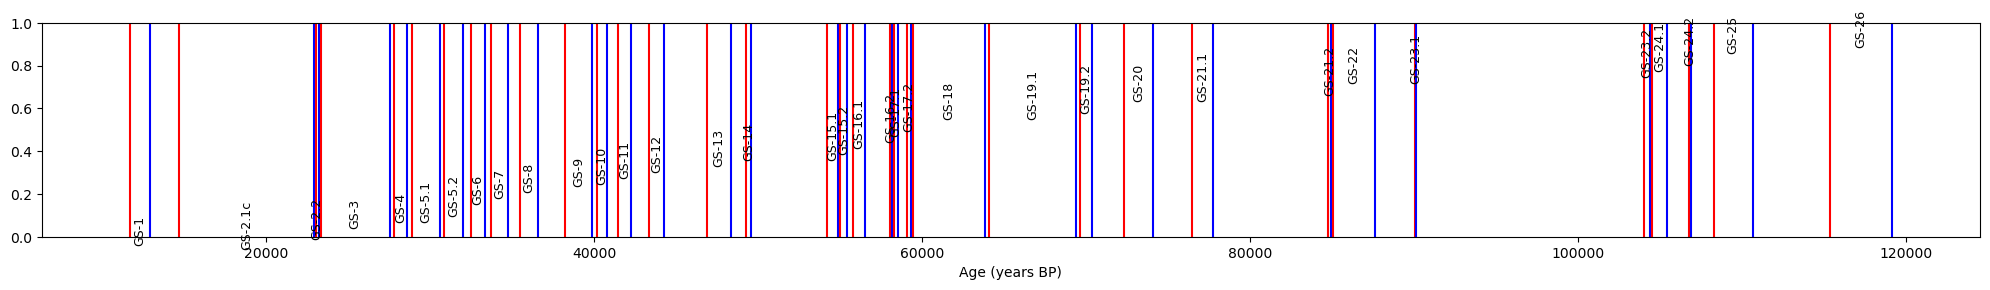

In [ ]:
visualize_transitions(data)
